<a href="https://colab.research.google.com/github/DimpleB0501/eva8/blob/main/Session_2.5_Assignment/assigment25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST dataset train and test

In [1]:
!pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import torch
import torchvision # provide access to datasets, models, transforms, utils, etc
import torchvision.transforms as transforms

In [3]:
print ("Pytorch version:", torch.__version__)

Pytorch version: 1.13.0+cu116


Select GPU mode

In [4]:
# Check if GPU available
if torch.cuda.is_available():
  print ("On GPU")
else :
  print ("No GPU available")
     
device = 'cuda' if torch.cuda.is_available() else 'cpu'

On GPU


# Creating a custom dataset

In [5]:
import random
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset

In [6]:
mnist =  torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform = transforms.Compose([
          transforms.ToTensor()
    ])
)

### One value in dataset

In [7]:
train_loader = torch.utils.data.DataLoader(mnist, batch_size = 1, shuffle=True)

label: tensor(2)
Random number generated: tensor(3)
Addition(randnum+image): tensor(5)
Image:


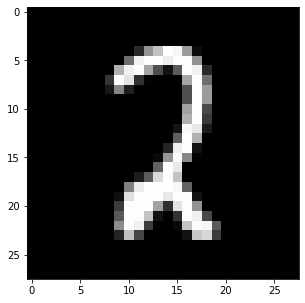

In [8]:
# creating custom dataset
class MyDataset(Dataset):
  def __init__(self):
    batch = next(iter(train_loader))
    self.data = batch[0]
    self.label = batch[1]

  def __getitem__(self, index):
    image = self.data[index]
    label = self.label[index]
    z = torch.tensor(random.randint(0, 9))
    #z_oh = one_hot (z)
    #return image, label, z_oh, label+z
    return image, label, z, label+z
   

  def __len__(self):
    return len(self.data)

myData = MyDataset()

for m in myData:
  print ("label:", m[1])
  print ("Random number generated:", m[2])
  print ("Addition(randnum+image):", m[3])
  print ("Image:")
  grid = torchvision.utils.make_grid(m[0], nrow=10)
  plt.figure(figsize=(5,5))
  plt.imshow(np.transpose(grid, (1,2,0)))

#print ("here", len(myData))

### Custom dataset

In [9]:
# one hot encoding
def one_hot (integer):
  rand_number = torch.zeros(28, 28)
  rand_number[:,] =1
  one_hot=torch.zeros(28)
  one_hot[integer]=1
  rand_number = rand_number * one_hot
  #print (rand_number)
  #print (rand_number.shape)
  rand_number = rand_number.unsqueeze(dim=0)
  return rand_number

In [10]:
def one_hot_label(label):
  rand_number = torch.zeros(1, 20)
  rand_number[:,] =1
  one_hot=torch.zeros(20)
  one_hot[label]=1
  rand_number = rand_number * one_hot
  #print (rand_number)
  rand_number = rand_number.squeeze(dim=0)
  return rand_number

In [11]:
class CustomDataset(Dataset):
  def __init__(self, batch_size = 50000):
    train_loader = torch.utils.data.DataLoader(mnist, batch_size = batch_size, shuffle=True)
    batch = next(iter(train_loader))
    self.data = batch[0]
    self.label = batch[1]

  def __getitem__(self, index):
    image = self.data[index]
    label = self.label[index]
    z = torch.tensor(random.randint(0, 9))
    z_oh = one_hot(z)
    label_add = one_hot_label(label+z)
    return image, label, z_oh, label_add

  def __len__(self):
    return len(self.data)

'''
for m in data:
  print ("label:", m[1])
  print ("Random number generated:", m[2])
  print ("Addition(randnum+image):", m[3])
  print ("Image:")
  grid = torchvision.utils.make_grid(m[0], nrow=10)
  plt.figure(figsize=(2,2))
  plt.imshow(np.transpose(grid, (1,2,0)))
'''


'\nfor m in data:\n  print ("label:", m[1])\n  print ("Random number generated:", m[2])\n  print ("Addition(randnum+image):", m[3])\n  print ("Image:")\n  grid = torchvision.utils.make_grid(m[0], nrow=10)\n  plt.figure(figsize=(2,2))\n  plt.imshow(np.transpose(grid, (1,2,0)))\n'

# Create a model

In [12]:
import torch.nn.functional as F
import torch.optim as optim

In [13]:
class LeNet(torch.nn.Module):
     
  def __init__(self):   
        super(LeNet, self).__init__()
        # Convolution (In LeNet, 32x32 images are given as input. Hence padding of 2 is done below)
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2, bias=True)
        # Max-pooling
        self.max_pool_1 = torch.nn.MaxPool2d(kernel_size=2)
        # Convolution
        self.conv2 = torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0, bias=True)
        # Max-pooling
        self.max_pool_2 = torch.nn.MaxPool2d(kernel_size=2)

        # Fully connected layer
        self.fc1 = torch.nn.Linear(16*5*5, 120)   # convert matrix with 16*5*5 (= 400) features to a matrix of 120 features (columns)
        self.fc2 = torch.nn.Linear(120, 84)       # convert matrix with 120 features to a matrix of 84 features (columns)
        self.fc3 = torch.nn.Linear(84, 10)        # convert matrix with 84 features to a matrix of 10 features (columns)
        self.fc4 = torch.nn.Linear(84, 19)        # for addition of MNIST prediction with random number

  def forward(self, x, y):
        # convolve, then perform ReLU non-linearity
        x = torch.nn.functional.relu(self.conv1(x))  
        y = torch.nn.functional.relu(self.conv1(y)) 
        # max-pooling with 2x2 grid
        x = self.max_pool_1(x)
        y = self.max_pool_1(y)

        # convolve, then perform ReLU non-linearity
        x = torch.nn.functional.relu(self.conv2(x))
        y = torch.nn.functional.relu(self.conv2(y))
        # max-pooling with 2x2 grid
        x = self.max_pool_2(x)
        y = self.max_pool_2(y)

        # first flatten 'max_pool_2_out' to contain 16*5*5 columns
        # read through https://stackoverflow.com/a/42482819/7551231
        x = x.view(-1, 16*5*5)
        y = y.view(-1, 16*5*5)
        
        z = torch.cat((x,y), 0)

        #print (z.shape)
        # FC-1, then perform ReLU non-linearity
        x = torch.nn.functional.relu(self.fc1(x))
        z = torch.nn.functional.relu(self.fc1(z))
        # FC-2, then perform ReLU non-linearity
        x = torch.nn.functional.relu(self.fc2(x))
        z = torch.nn.functional.relu(self.fc2(z))
        # FC-3
        x = self.fc3(x)
        z = self.fc4(z)
        return x, z

In [14]:
model = LeNet()
model.to(device)

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (max_pool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (max_pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (fc4): Linear(in_features=84, out_features=19, bias=True)
)

### Train the model

In [15]:
def get_num_correct(preds, labels):
  return preds.argmax(dim=1).eq(labels).sum().item()

In [16]:
data = CustomDataset(len(mnist)) # 256 is the batch size
#print (len(data))
loader = torch.utils.data.DataLoader(data, batch_size=250)
optimizer = optim.Adam(model.parameters(), lr=0.01)

for epoch in range(10):
  total_loss_1 = 0
  total_correct_1 = 0
  total_loss_2 = 0
  total_correct_2 = 0
  for images, labels, rd, rl in loader: # Get Batch
      #print (images.size(), labels.size(), rd.size(), rl.size())
      images = images.to(device)
      labels = labels.to(device)
      rd = rd.to(device)
      rl = rl.to(device)

      preds1, preds2 = model(images, rd) # Pass Batch of images and one hot encoded random number

      loss1 = F.cross_entropy(preds1, labels) # Calculate Loss1
      #loss2 = F.cross_entropy(preds2, rl) # Calculate Loss2

      optimizer.zero_grad()

      loss1.backward() # Calculate Gradients
      #loss2.backward() # Calculate Gradients

      optimizer.step() # Update Weights

      total_loss_1 += loss1.item()
      total_correct_1 += get_num_correct(preds1, labels)

      #total_loss_2 += loss2.item()
      #total_correct_2 += get_num_correct(preds2, rl)

  print(
      "epoch:", epoch, "\n",
      "MNIST-LENET Architecture: { "
      #"total_correct:", total_correct/len(train_set)*100, 
      "accuracy(percentage):", total_correct_1/len(mnist)*100,
      #"loss:", total_loss/len(train_loader)
      "loss:", total_loss_1,"}\n"
      #"MNIST+RAND_NO: { "
      #"total_correct:", total_correct/len(train_set)*100, 
      #"accuracy(percentage):", total_correct_2/len(mnist)*100,
      #"loss:", total_loss/len(train_loader)
      #"loss:", total_loss_2,"}"
  )

epoch: 0 
 MNIST-LENET Architecture: { accuracy(percentage): 91.60000000000001 loss: 61.30733905173838 }

epoch: 1 
 MNIST-LENET Architecture: { accuracy(percentage): 97.77 loss: 17.690157397650182 }

epoch: 2 
 MNIST-LENET Architecture: { accuracy(percentage): 98.29666666666667 loss: 13.126036568544805 }

epoch: 3 
 MNIST-LENET Architecture: { accuracy(percentage): 98.66666666666667 loss: 10.58143703918904 }

epoch: 4 
 MNIST-LENET Architecture: { accuracy(percentage): 98.715 loss: 10.153607407351956 }

epoch: 5 
 MNIST-LENET Architecture: { accuracy(percentage): 98.92833333333333 loss: 8.544234918430448 }

epoch: 6 
 MNIST-LENET Architecture: { accuracy(percentage): 98.94666666666667 loss: 8.269532244943548 }

epoch: 7 
 MNIST-LENET Architecture: { accuracy(percentage): 98.99166666666666 loss: 8.221567357133608 }

epoch: 8 
 MNIST-LENET Architecture: { accuracy(percentage): 98.965 loss: 8.755280618555844 }

epoch: 9 
 MNIST-LENET Architecture: { accuracy(percentage): 98.9966666666666